# U.S. Treasury Yield Curve Forecasting using VAR+PCA


In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
%matplotlib inline

## Import data

In [2]:
# Import yield data from the data folder
df = pd.read_csv('../data/yield.csv')
df = df.set_index('DATE')
df.index = pd.to_datetime(df.index)
name = list(df.columns.values)

df

,1MO,3MO,6MO,1YR,2YR,3YR,5YR,7YR,10YR,20YR,30YR
DATE,,,,,,,,,,,
2005-01-03,1.99,2.32,2.63,2.79,3.10,3.28,3.64,3.94,4.23,4.84,4.85
2005-01-04,2.05,2.33,2.63,2.82,3.20,3.38,3.72,4.02,4.29,4.91,4.91
2005-01-05,2.04,2.33,2.63,2.83,3.22,3.39,3.73,4.02,4.29,4.88,4.88
2005-01-06,2.04,2.31,2.63,2.82,3.18,3.36,3.71,4.01,4.29,4.88,4.89
2005-01-07,2.03,2.32,2.63,2.82,3.20,3.40,3.73,4.03,4.29,4.88,4.88
...,...,...,...,...,...,...,...,...,...,...,...
2025-09-03,4.35,4.18,3.96,3.77,3.61,3.58,3.69,3.92,4.22,4.85,4.90
2025-09-04,4.33,4.16,3.94,3.76,3.59,3.55,3.65,3.87,4.17,4.81,4.86
2025-09-05,4.29,4.07,3.85,3.65,3.51,3.48,3.59,3.80,4.10,4.72,4.78


In [10]:
# Split into training and test data
train_stop = -756  # by slicing index (3 years business calendar ahead)
df_train = df.iloc[:train_stop]
df_test = df.iloc[train_stop:]

## PCA Analysis

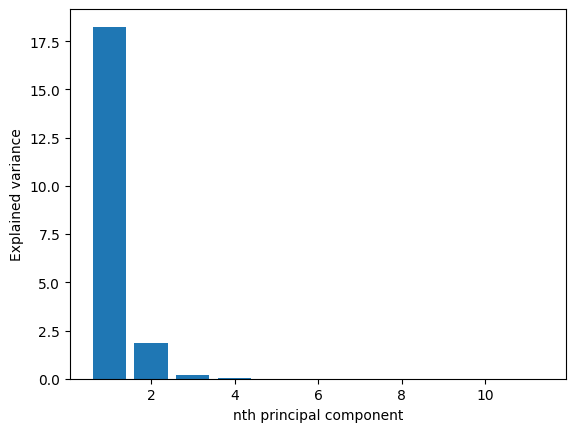

In [11]:
# Center the train data before PCA
yield_mean = df_train.mean()
df_c = df - yield_mean
df_train_c = df_train - yield_mean

# Examine the main contributing components
# Get all principal components of PCA
pca_all = PCA(n_components=df.shape[1])
pca_all.fit(df_train_c)
loadings = pca_all.components_

# Plot explained variance of each component
explained_var = pca_all.explained_variance_
plt.bar(np.arange(1,12),explained_var)
plt.xlabel('nth principal component')
plt.ylabel('Explained variance')
plt.show()

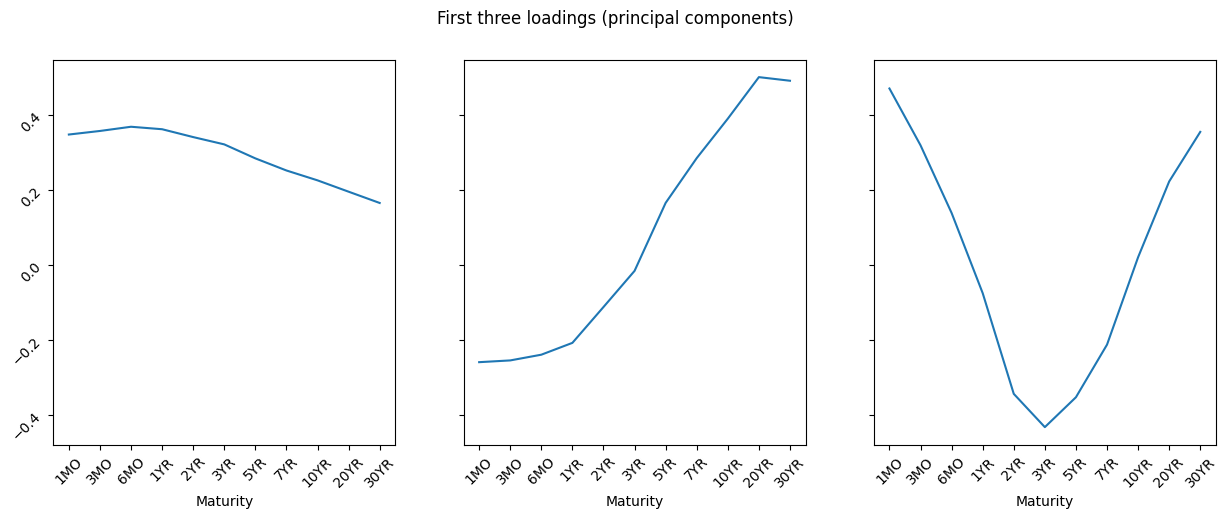

In [12]:
# Get the first three components
pca = PCA(n_components=3)
pca.fit(df_train_c)
loadings = pca.components_

# Plot the first three components
fig, ax = plt.subplots(1,3,figsize=(15,5), sharey=True)
ax[0].plot(loadings[0])
ax[0].set_xticks(np.arange(0,11), name)
ax[0].tick_params(labelrotation=45)
ax[0].set_xlabel('Maturity')
ax[1].plot(loadings[1])
ax[1].set_xticks(np.arange(0,11), name)
ax[1].tick_params(labelrotation=45)
ax[1].set_xlabel('Maturity')
ax[2].plot(loadings[2])
ax[2].set_xticks(np.arange(0,11), name)
ax[2].tick_params(labelrotation=45)
ax[2].set_xlabel('Maturity')
fig.suptitle('First three loadings (principal components)')
plt.show()

In [13]:
# Represent the original training data in a basis of the first three loadings
scores = df_c.to_numpy() @ loadings.T
scores_train = df_train_c.to_numpy() @ loadings.T
scores_train

array([[ 4.39665973,  1.4458619 , -0.27149444],
       [ 4.57865118,  1.5330725 , -0.32675398],
       [ 4.58084091,  1.50305175, -0.36429343],
       ...,
       [ 4.13156496, -1.35902988, -0.51990641],
       [ 4.1673279 , -1.37905978, -0.59622536],
       [ 4.37171775, -1.33747854, -0.58823088]], shape=(4420, 3))

## Test stationarity

In [14]:
# Test the stationarity of each score using ADF test
from statsmodels.tsa.stattools import adfuller

def adf_test(series, alpha=0.05):
    """Return True if stationary and False otherwise"""
    res = adfuller(series, autolag='AIC')
    pval = res[1]
    return pval < alpha

print("Stationarity of raw scores series")
print(f"The 1st score (level) : {adf_test(scores_train[:,0])}")
print(f"The 2nd score (slope) : {adf_test(scores_train[:,1])}")
print(f"The 3rd score (curve) : {adf_test(scores_train[:,2])}")

Stationarity of raw scores series
The 1st score (level) : False
The 2nd score (slope) : False
The 3rd score (curve) : False


In [15]:
# Take the difference series and recheck
scores_train_diff = []
for i in range(1,len(scores_train)):
    scores_train_diff.append(scores_train[i]-scores_train[i-1])
    
scores_train_diff = np.array(scores_train_diff)

print("Stationarity of score difference")
print(f"The 1st score_diff : {adf_test(scores_train_diff[:,0])}")
print(f"The 2nd score_diff : {adf_test(scores_train_diff[:,1])}")
print(f"The 3rd score_diff : {adf_test(scores_train_diff[:,2])}")

Stationarity of score difference
The 1st score_diff : True
The 2nd score_diff : True
The 3rd score_diff : True


## Forcasting using VAR (Vector Autoregression)

We use two versions: 
1. Fitting VAR using scores (nonstationary)
2. Fitting VAR using scores_diff (stationary)

In [16]:
# Use VAR (Vector Autoregression) to model the dynamics of the difference of scores
var_model_1 = VAR(scores_train)
var_model_2 = VAR(scores_train_diff)

maxlag = 20
var_res_1 = var_model_1.fit(maxlags=maxlag, ic='aic')
var_res_2 = var_model_2.fit(maxlags=maxlag, ic='aic')      # Set max la = 15

In [40]:
# Forecast score using the fitted VAR model

horizons = [21, 63, 126, 252]  # 1/3/6/12 months ahead

def produce_forecasts(model, horizon):
    fore = []
    for i in range(len(df_test)):
        fore.append(model.forecast(scores[-len(df_test)-model.k_ar-horizon+1+i : -len(df_test)-horizon+1+i], steps=1)[-1])
    return np.array(fore)

# Version 1 (raw score)
score_fore_1 = []
for h in horizons:
    score_fore_1.append(produce_forecasts(var_res_1, h))
    
# Transform the forecasted scores back to yields
yield_fore_1 = []    # forecasts of 1/3/6/12 months ahead
for fore in score_fore_1:
    yield_fore_1.append(yield_mean + pd.DataFrame(fore @ loadings, columns=df.columns, index=df_test.index))
 
yield_fore_1[0]  # forecasts of one month ahead

,1MO,3MO,6MO,1YR,2YR,3YR,5YR,7YR,10YR,20YR,30YR
DATE,,,,,,,,,,,
2022-08-30,2.463741,2.593045,2.767806,2.842641,2.875217,2.862392,2.796413,2.777277,2.747332,2.906819,2.935511
2022-08-31,2.466075,2.623646,2.833377,2.944969,3.027197,3.035487,2.969077,2.932936,2.870948,3.002908,2.999058
2022-09-01,2.409260,2.578820,2.802344,2.931270,3.033471,3.046090,2.966652,2.915031,2.829801,2.941237,2.929062
2022-09-02,2.439382,2.592772,2.796948,2.904012,2.978996,2.982786,2.912126,2.875760,2.815104,2.948102,2.951377
2022-09-06,2.479463,2.665215,2.909025,3.055701,3.181225,3.203555,3.122566,3.059984,2.957217,3.052657,3.017318
...,...,...,...,...,...,...,...,...,...,...,...
2025-09-03,4.330407,4.276633,4.245851,4.009746,3.672033,3.569562,3.706853,3.921883,4.273693,4.758324,4.845731
2025-09-04,4.348807,4.298183,4.270708,4.037009,3.699193,3.593167,3.718961,3.924370,4.265681,4.739981,4.823909
2025-09-05,4.328013,4.273627,4.242216,4.005598,3.667875,3.566124,3.705776,3.922753,4.276712,4.763443,4.851430


In [48]:
# RMSE table

def RMSE_table(yield_fores):
    RMSE = []
    for yield_fore in yield_fores:
        RMSE.append(np.sqrt(np.mean((yield_fore.to_numpy() - df_test.to_numpy())**2, axis=0)))
    RMSE = np.array(RMSE)
    ind = ['1', '3', '6', '12']
    return pd.DataFrame(RMSE, columns=df.columns, index=ind)

# Save results
RMSE_table(yield_fore_1).to_csv('../results/VAR-PCA_RMSE.csv', index=False)
RMSE_table(yield_fore_1)

,1MO,3MO,6MO,1YR,2YR,3YR,5YR,7YR,10YR,20YR,30YR
1,0.250888,0.242327,0.303781,0.340739,0.318757,0.331429,0.335269,0.328042,0.296134,0.313885,0.277141
3,0.533233,0.608146,0.658103,0.653178,0.577699,0.568549,0.548855,0.530657,0.478648,0.492856,0.413218
6,1.220106,1.280541,1.262163,1.137643,0.848625,0.725551,0.626257,0.602951,0.563714,0.620392,0.523786
12,2.410694,2.452473,2.396374,2.189754,1.750315,1.519327,1.263912,1.149372,1.055995,1.079480,0.915889


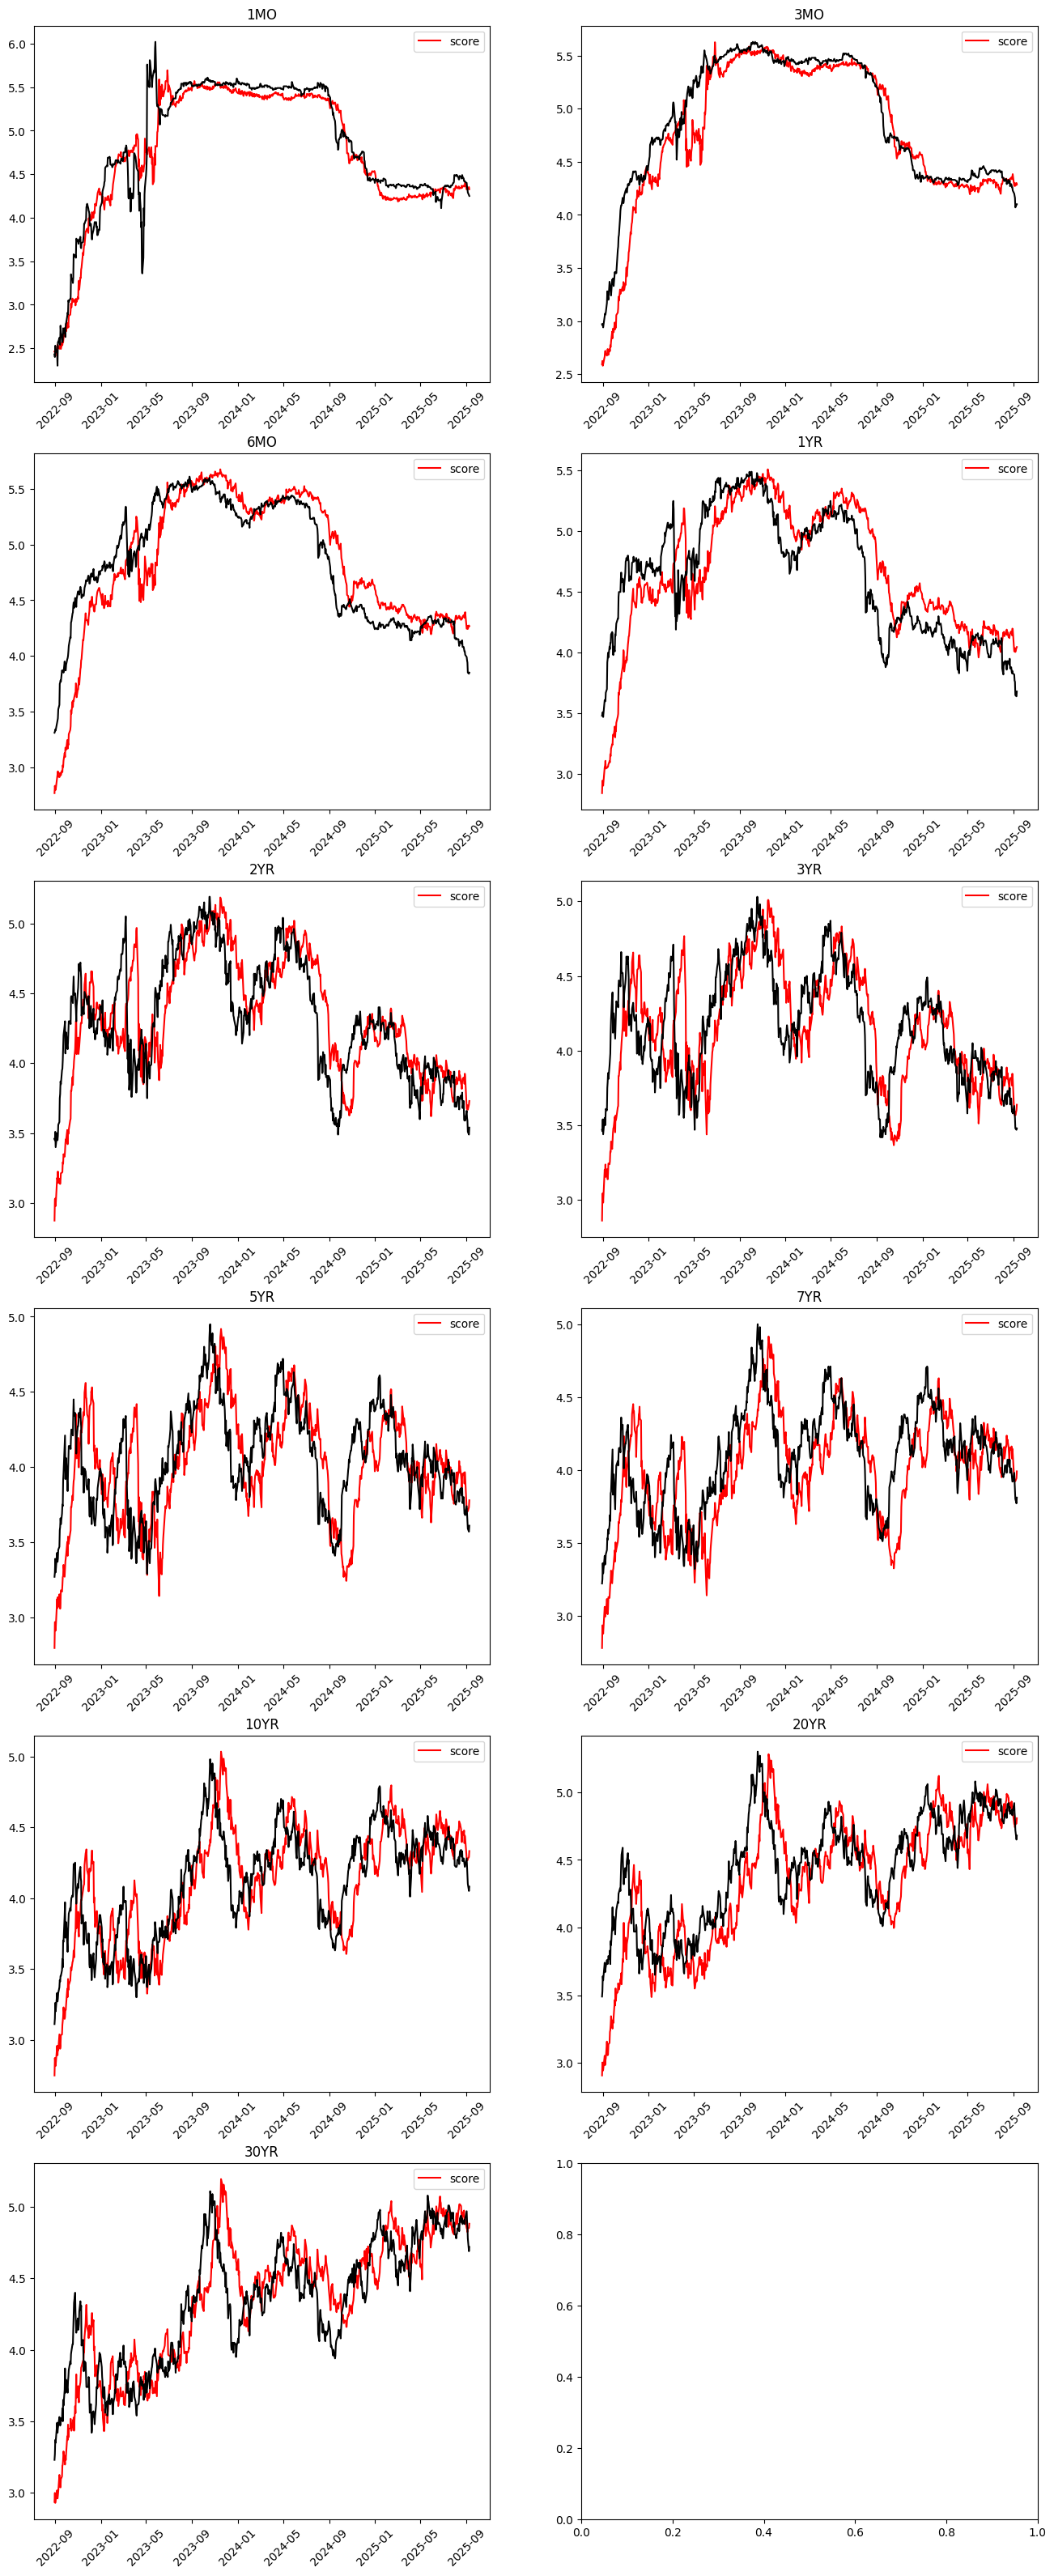

In [44]:
# Plot the forecasted (1 month ahead) vs actual yield
fig, ax = plt.subplots(6,2,figsize=(16,40))

for i in range(6):
    for j in range(2):
        ind = 2*i+j
        if ind == len(name): break
        ax[i, j].plot(yield_fore_1[0][name[ind]], color='red', label='score')
        #ax[i, j].plot(yield_fore_2[name[ind]], color='blue', label='score_diff')
        ax[i, j].plot(df_test[name[ind]], color='black')
        ax[i, j].legend()
        ax[i, j].tick_params('x', labelrotation=45)
        ax[i, j].set_title(name[ind])